<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Shopee matching problem using Siamese-inspired approach

## Import

In [1]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32754, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 32754 (delta 172), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32754/32754), 1.69 GiB | 26.70 MiB/s, done.
Resolving deltas: 100% (230/230), done.
Checking out files: 100% (32430/32430), done.


In [2]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [3]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from keras import backend

import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
import seaborn as sns

from pathlib import Path

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Load and preprocess datasets

In [4]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
train_img_dir = Path('DeepLearning20211/data/train_images')

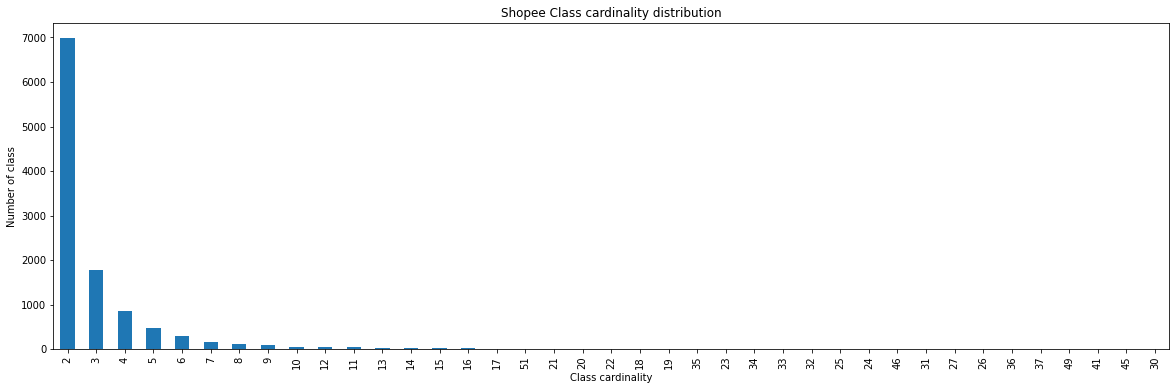

In [5]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

In [46]:
#@title Create validation set

train_df['index'] = train_df.index
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.set_index('index')
train_df = train_df.drop('index', axis=1)
train_df = train_df.drop(index=val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

In [47]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label_group'])

LabelEncoder()

In [8]:
batch_size = 64

data_augmentation = tf.keras.Sequential(
    [
     layers.RandomRotation(0.5),
     layers.RandomContrast(0.5),
     layers.RandomZoom((-0.2, 0.2)),
     layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    return img

def configure_dataset(ds, mode, fine_tune=False):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    ds = ds.map(lambda filepath, label: (filepath_to_img(filepath), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.map(lambda img, label: (layers.Resizing(224, 224, crop_to_aspect_ratio=True)(img), label),
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.map(lambda img, label: (data_augmentation(img), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    if not fine_tune:               # we'll use some available preprocessing in keras model
        ds = ds.map(lambda img, label: (layers.Rescaling(1./255, offset=-1)(img), label),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.prefetch(buffer_size=2048)
    ds = ds.batch(batch_size)
    
    return ds

## Define model and utilities

In [9]:
#@title Define embedding model (Run only once)
base_model = applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False, include_preprocessing=True)

output = layers.Flatten()(base_model.output)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

embedding = Model(base_model.input, output, name='Embedding')

17620992/17605208 [==============================] - 0s 0us/step


In [ ]:
embedding.summary()

In [10]:
#@title Choose layer to freeze

layer_name = 'multiply_14' #@param {type: 'string'}

trainable = False
for layer in base_model.layers:
    if layer.name == layer_name:
        trainable = True
    layer.trainable = trainable




In [68]:
batch_loss_histories = {}
epoch_loss_histories = {'loss': [], 'val_loss': []}
best_weights = None

!rm -rf ./logs/

train_summary_writer = tf.summary.create_file_writer('logs/scalar/train')
val_summary_writer = tf.summary.create_file_writer('logs/scalar/val')
lr_summary_writer = tf.summary.create_file_writer('logs/scalar/lr')
image_summary_writer = tf.summary.create_file_writer('logs/images')

In [67]:
class MyCallback(callbacks.Callback):
    def __init__(self, train_summary_writer, val_summary_writer, lr_summary_writer, reduce_lr=True, restore_best_weights=True):
        super(MyCallback, self).__init__()
        self.epoch = max(batch_loss_histories.keys()) + 1 if len(batch_loss_histories) > 0 else 0
        batch_loss_histories[self.epoch] = []

        self.reduce_lr = reduce_lr
        self.restore_best_weights = restore_best_weights

        self.train_summary_writer = train_summary_writer
        self.val_summary_writer = val_summary_writer
        self.lr_summary_writer = lr_summary_writer

    def on_train_batch_end(self, batch, logs={}):
        batch_loss_histories[self.epoch].append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):

        with self.lr_summary_writer.as_default():
            tf.summary.scalar('learning rate', backend.get_value(self.model.optimizer.lr), step=len(epoch_loss_histories['val_loss']))

        if self.reduce_lr and len(epoch_loss_histories['loss']) > 0 and logs.get('loss') > epoch_loss_histories['loss'][-1]:
            new_lr = backend.get_value(self.model.optimizer.lr) / 10.0
            backend.set_value(self.model.optimizer.lr, new_lr)
            print("\n[MyCallback]: Learning rate reduced to {}.".format(new_lr))

        if self.restore_best_weights and (len(epoch_loss_histories['val_loss']) == 0 or logs.get('val_loss') < min(epoch_loss_histories['val_loss']) - 1e-4):
            best_weights = self.model.get_weights()
            print("\n[MyCallback]: Best weights on val_loss saved to 'best_weight'.")

        epoch_loss_histories['loss'].append(logs.get('loss'))
        epoch_loss_histories['val_loss'].append(logs.get('val_loss'))

        with self.train_summary_writer.as_default():
            tf.summary.scalar('loss', logs.get('loss'), step=len(epoch_loss_histories['loss']) - 1)
        
        with self.val_summary_writer.as_default():
            tf.summary.scalar('loss', logs.get('val_loss'), step=len(epoch_loss_histories['val_loss']) - 1)

In [16]:
def get_train_ds(train_df):
    train_df = train_df.sample(frac=1.0).reset_index(drop=True)
    train_ds = pd.concat([train_df, train_df]).sort_index(axis=0)
    train_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + train_ds['image'], label_encoder.transform(train_ds['label_group'])))
    train_ds = configure_dataset(train_ds, mode='training', fine_tune=True)     # training using keras pretrained-model

    return train_ds

In [48]:
val_ds = pd.concat([val_df, val_df]).sort_index(axis=0)
val_labels = label_encoder.transform(val_ds['label_group'])
val_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + val_ds['image'], val_labels))
val_ds = configure_dataset(val_ds, mode='validation', fine_tune=True)   # evaluation using keras pretrained-model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


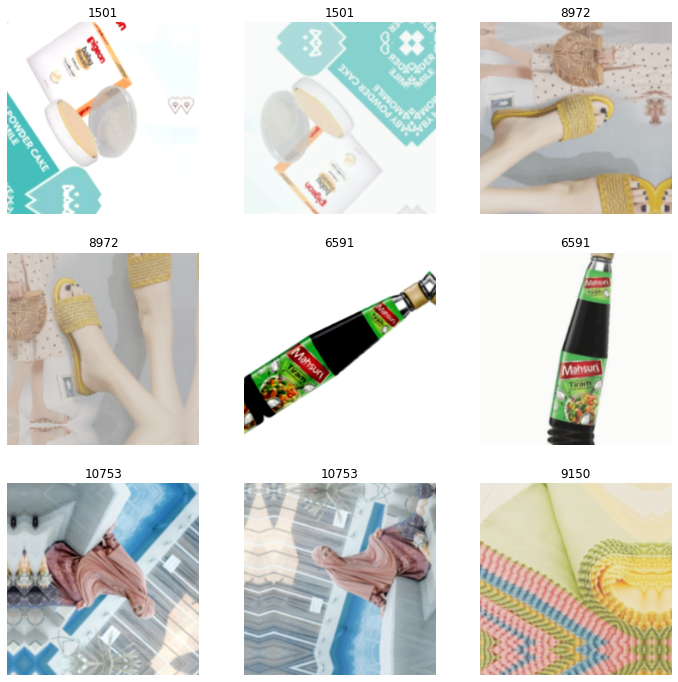

In [ ]:
#@title Plot some training images
ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for img_batch, label_batch in get_train_ds(train_df).take(1):
    with image_summary_writer.as_default():
            tf.summary.image('training image', img_batch/255, max_outputs=64, step=0)
    i = 0
    for img, label in zip(img_batch, label_batch):
        plt.subplot(spec[i])
        plt.imshow(img/255)
        plt.title(label.numpy())
        plt.axis('off')

        i += 1
        if i == nrows * ncols:
            break
plt.show()

## Train and evaluate model

In [ ]:
embedding.compile(
    optimizer=SGD(learning_rate=5e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    )

num_epoch = 5
max_epoch = num_epoch + (len(epoch_loss_histories['loss']) if len(batch_loss_histories) > 0 else 0)
for _ in range(num_epoch):
    train_ds = get_train_ds(train_df)

    current_epoch = len(epoch_loss_histories['loss']) if len(batch_loss_histories) > 0 else 0

    print('Epoch %d/%d' % (current_epoch + 1, max_epoch))

    embedding.fit(
        train_ds,
        epochs=1,
        validation_data=val_ds,
        callbacks=[MyCallback(train_summary_writer, val_summary_writer, lr_summary_writer, reduce_lr=True, restore_best_weights=True)]
    )

In [ ]:
#@title Create anchor embeddings

%%time

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

anchor_df['label_group'] = anchor_df.index
anchor_df = anchor_df.reset_index(drop=True)

num_per_anchor = 4

anchor_df = pd.concat([anchor_df for _ in range(num_per_anchor)]).sort_index(axis=0)
anchor_labels = label_encoder.transform(anchor_df['label_group'])
anchor_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + anchor_df['image'], anchor_labels))
anchor_ds = configure_dataset(anchor_ds, mode='training', fine_tune=True)
anchor_embeddings = embedding.predict(anchor_ds)

pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(anchor_embeddings)

print('Anchor embeddings created')

CPU times: user 20min 5s, sys: 41.7 s, total: 20min 47s
Wall time: 14min 10s


In [ ]:
with open('/content/drive/MyDrive/checkpoint/anchor_embeddings.pkl', 'wb') as f:
    pickle.dump(anchor_embeddings, f)

with open('/content/drive/MyDrive/checkpoint/anchor_labels.pkl', 'wb') as f:
    pickle.dump(anchor_labels, f)

In [ ]:
#@title Use KNN for classification task

%%time
KNN = KNeighborsClassifier(n_neighbors=num_per_anchor)
KNN.fit(anchor_embeddings, anchor_labels)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
#@title Calculate embeddings for validation set

%%time

val_embeddings = embedding.predict(val_ds)

CPU times: user 10min 2s, sys: 22.7 s, total: 10min 25s
Wall time: 7min 22s


In [ ]:
#@title Predict class probabilities for each validation image

%%time

val_preds = KNN.predict_proba(val_embeddings)

CPU times: user 2min 36s, sys: 17.1 s, total: 2min 53s
Wall time: 1min 57s


In [ ]:
#@title Top-K accuracy

k = 5 #@param {type: "integer"}

top_k_accuracy_score(val_labels, val_preds, k=k)

0.5282367895405847

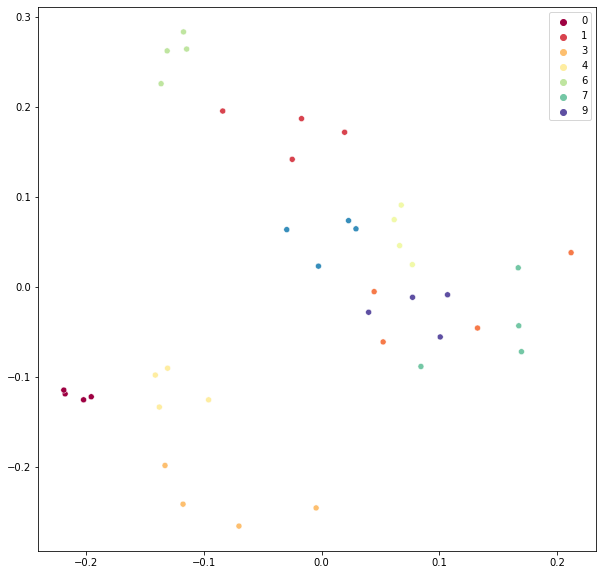

In [ ]:
#@title Visualize anchor embeddings on 2D plane

num_class = 10 #@param {type: 'integer'}
plt.figure(figsize=(10, 10))
sns.scatterplot(x=decomposed_embeddings[:num_per_anchor * num_class, 0], 
                y=decomposed_embeddings[:num_per_anchor * num_class, 1], 
                hue=anchor_labels[:num_per_anchor * num_class], 
                palette=cm.get_cmap('Spectral')
)

In [ ]:
embedding.save('/content/drive/MyDrive/checkpoint/embedding')

In [ ]:
embedding = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding')

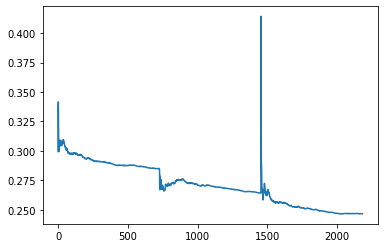

In [ ]:
all_losses = []
for _ in range(len(batch_loss_histories)): all_losses.extend(batch_loss_histories[_])
plt.plot(range(len(all_losses)), all_losses)
plt.show()

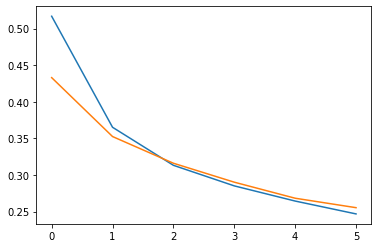

In [ ]:
max_epoch = len(epoch_loss_histories['loss'])
plt.plot(range(max_epoch), epoch_loss_histories['loss'], label='loss')
plt.plot(range(max_epoch), epoch_loss_histories['val_loss'], label='val_loss')
plt.show()

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/scalar

# Testing

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "(optional) My latest experiment" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot

In [ ]:
from tensorboard.plugins import projector



# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='/logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in encoder.subwords:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown".
  for unknown in range(1, encoder.vocab_size - len(encoder.subwords)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
https://www.tensorflow.org/tensorboard/tensorboard_profiling_keras

## Define model and utilities

In [61]:
batch_loss_histories = {}
epoch_loss_histories = {'loss': [], 'val_loss': []}
best_weights = None

## Train and evaluate model

In [64]:
embedding.compile(
    optimizer=SGD(learning_rate=5e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    )

num_epoch = 3
max_epoch = num_epoch + (len(epoch_loss_histories['loss']) if len(batch_loss_histories) > 0 else 0)
for _ in range(num_epoch):
    train_ds = get_train_ds(train_df)

    current_epoch = len(epoch_loss_histories['loss']) if len(batch_loss_histories) > 0 else 0

    print('Epoch %d/%d' % (current_epoch + 1, max_epoch))

    embedding.fit(
        train_ds,
        epochs=1,
        validation_data=val_ds,
        callbacks=[MyCallback(reduce_lr=True, restore_best_weights=True)]
    )

Epoch 4/6
4/4 [==============================] - 27s 5s/step - loss: 0.6965 - val_loss: 0.6976
Epoch 5/6
4/4 [==============================] - 20s 5s/step - loss: 0.6841 - val_loss: 0.6889
Epoch 6/6
4/4 [==============================] - ETA: 0s - loss: 0.7007
[MyCallback]: Learning rate reduced to 0.0004999999888241291.
4/4 [==============================] - 19s 5s/step - loss: 0.7007 - val_loss: 0.6570
